In [1]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv
from pprint import pprint

# Load environment variables from .env
load_dotenv()
# Add src folder to path
project_root = Path.cwd().parent  # assumes notebook is in child folder
src_path = project_root / "sources"
sys.path.append(str(src_path))
from core.llm import OpenRouterClient
from utils.generate_dsl_docs import generate_symbolic_dsl_reference_markdown
from agents.agents_utils import MultiGridFeatureCollector, SymbolicGridMapper

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# json_file = "/workspaces/arcprize2025/datas/arc-agi_training_challenges.json"
# json_file = r"C:\Users\UT00YBG3\Documents\arcprize2025\datas\arc-agi_training_challenges.json"
json_file = "/home/yann/ssd_storage/python/arcprize2025/datas/arc-agi_training_challenges.json"

In [13]:
import json
import matplotlib.pyplot as plt
import numpy as np


def plot_grid(grid, title=""):
    """
    Plots a single 2D grid using matplotlib.
    
    Parameters:
    - grid: List of lists of integers.
    - title: Optional title for the plot.
    """
    grid_array = np.array(grid)
    plt.figure(figsize=(2, 2))
    plt.imshow(grid_array, cmap='tab20', interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.show()

{'input': [[6, 6, 0], [6, 0, 0], [0, 6, 6]], 'output': [[6, 6, 0, 6, 6, 0, 0, 0, 0], [6, 0, 0, 6, 0, 0, 0, 0, 0], [0, 6, 6, 0, 6, 6, 0, 0, 0], [6, 6, 0, 0, 0, 0, 0, 0, 0], [6, 0, 0, 0, 0, 0, 0, 0, 0], [0, 6, 6, 0, 0, 0, 0, 0, 0], [0, 0, 0, 6, 6, 0, 6, 6, 0], [0, 0, 0, 6, 0, 0, 6, 0, 0], [0, 0, 0, 0, 6, 6, 0, 6, 6]]}


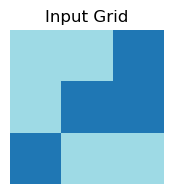

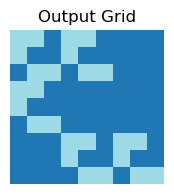

In [14]:
n=1


with open(json_file, 'r') as file:
    data = json.load(file)

data.keys()
list_number = list(data.keys())
puzzle = data[list_number[n]]
example_0= puzzle["train"][0]
print(example_0)
plot_grid(example_0["input"], title="Input Grid")
plot_grid(example_0["output"], title="Output Grid")

In [16]:
mapper = SymbolicGridMapper()
symbolic_variants = mapper.generate_variants(puzzle, symbol_set_ids=["katakana_final_refined_1", "katakana_final_refined_2"])
symbolics_grids = mapper.format_variants_list(symbolic_variants)
doc_sigil = generate_symbolic_dsl_reference_markdown()


In [20]:
prompt = f"""
    you will solve puzzle, you have to find the rules.
    this is th docs:
    
    {doc_sigil}
    
    this is the grids:
    
    {symbolics_grids}
"""

In [22]:
print(prompt)


    you will solve puzzle, you have to find the rules.
    this is th docs:
    
    ### Apply To Row

                * **Symbolic Rules:**
                ```python
                {   'apply_to_row': {   'pattern': '^→\\((?P<row_idx>[IVX]+),\\s*(?P<inner_command>.+)\\)$',
                        'transform_params': <function <lambda> at 0x7fe3a4d19f80>}}
                    Synthesis Rules:

                {   'parameter_ranges': {'row_index': (0, 30)},
    'requires_inner': True,
    'type': 'combinator'}

                    Explanation:

                Applies a given transformation to a specific row in the grid.
            
            Use this to target transformations like FlipGridHorizontally, ReverseRow, etc. to one row only.
            
            Parameters:
            - inner_command: The transformation command to apply to the row.
            - row_index: The index of the row to transform.

            Example:
            Input: [[1, 2, 3],
                    [4